# 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas
import konlpy
import gensim

### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 분석할 데이터 준비
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): # 데이터 전처리 후 반환하는 함수
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train= []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) # 데이터 준비 완료

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 단어 인덱스 리스트 벡터로 반환함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 단어 인덱스 리스트 벡터로 encode 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장들을 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

max len:  116
mean len:  15.98170773419436


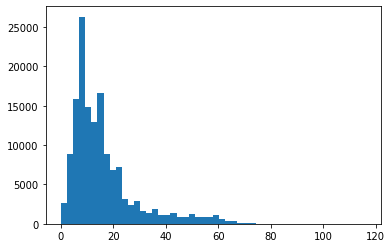

In [6]:
import matplotlib.pyplot as plt

print('max len: ', max(len(review) for review in X_train)) # 데이터셋 내 최대 문장 길이
print('mean len: ', sum(map(len, X_train))/len(X_train)) # 데이터셋 문장 길이 평균
plt.hist([len(review) for review in X_train], bins=50)
plt.show() # 문장 길이 분포 확인

In [7]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1
    print(f'최대 길이: {max_len}, 커버 가능한 샘플 비율: {(count/len(nested_list))*100}')

In [8]:
below_threshold_len(50, X_train) # 최대 길이 50일 때 96퍼센트의 샘플 커버 가능

최대 길이: 50, 커버 가능한 샘플 비율: 96.03439547960761


In [9]:
import tensorflow as tf
# 최대 문장 길이 50으로 결정
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre',maxlen=50)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre',maxlen=50)

### 4) 모델 구성 및 validation set 구성

#### (1) LSTM

In [45]:
# LSTM 모델 준비
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000 
word_vector_dim = 50
hidden_units = 30

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, word_vector_dim))
model_lstm.add(LSTM(hidden_units))
model_lstm.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # val_accuracy가 4번 떨어지면 학습 멈춤
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 509,751
Trainable params: 509,751
Non-trainable params: 0
_________________________________________________________________


#### (2) GRU

In [11]:
# GRU 모델 준비
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size=10000
word_vector_dim = 50
hidden_units = 30

model_gru = Sequential()
model_gru.add(Embedding(vocab_size, word_vector_dim))
model_gru.add(GRU(hidden_units))
model_gru.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
gru (GRU)                    (None, 30)                7380      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 507,411
Trainable params: 507,411
Non-trainable params: 0
_________________________________________________________________


#### (3) 1D CNN

In [12]:
# 1D CNN 모델 준비
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000
word_vector_dim_cnn = 16

model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, word_vector_dim_cnn))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, shuffle=True,\
                                                 stratify=y_train, random_state=1234)

### 5) 모델 훈련 개시

#### (1) LSTM

In [43]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512,\
                    validation_data=(X_val, y_val), verbose=1) # LSTM 훈련

Epoch 1/15
172/172 [==============================] - 3s 10ms/step - loss: 0.5282 - accuracy: 0.7529 - val_loss: 0.3991 - val_accuracy: 0.8284
Epoch 2/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3558 - accuracy: 0.8483 - val_loss: 0.3616 - val_accuracy: 0.8430
Epoch 3/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3205 - accuracy: 0.8651 - val_loss: 0.3558 - val_accuracy: 0.8457
Epoch 4/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3020 - accuracy: 0.8754 - val_loss: 0.3577 - val_accuracy: 0.8457
Epoch 5/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2904 - accuracy: 0.8807 - val_loss: 0.3566 - val_accuracy: 0.8454
Epoch 6/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2793 - accuracy: 0.8853 - val_loss: 0.3667 - val_accuracy: 0.8444
Epoch 7/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2657 - accuracy: 0.8927 - val_loss: 0.3683 - val_accuracy: 0.8447
Epoch

In [44]:
result_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(result_lstm) # LSTM 결과

1537/1537 - 3s - loss: 0.3699 - accuracy: 0.8438
[0.3698976933956146, 0.8438065648078918]


#### (2) GRU

In [16]:
history_gru = model_gru.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512, \
                        validation_data=(X_val, y_val), verbose=1) # GRU 훈련

Epoch 1/15
172/172 [==============================] - 3s 10ms/step - loss: 0.4683 - accuracy: 0.7794 - val_loss: 0.3697 - val_accuracy: 0.8367
Epoch 2/15
172/172 [==============================] - 1s 8ms/step - loss: 0.3311 - accuracy: 0.8593 - val_loss: 0.3582 - val_accuracy: 0.8461
Epoch 3/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3061 - accuracy: 0.8715 - val_loss: 0.3599 - val_accuracy: 0.8453
Epoch 4/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2904 - accuracy: 0.8785 - val_loss: 0.3690 - val_accuracy: 0.8453
Epoch 5/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2765 - accuracy: 0.8850 - val_loss: 0.3702 - val_accuracy: 0.8444
Epoch 6/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2613 - accuracy: 0.8923 - val_loss: 0.3716 - val_accuracy: 0.8468
Epoch 00006: early stopping


In [17]:
result_gru = model_gru.evaluate(X_test, y_test, verbose=2)
print(result_gru) # GRU 결과

1537/1537 - 3s - loss: 0.3731 - accuracy: 0.8439
[0.3731251060962677, 0.8438675999641418]


#### (3) 1D CNN

In [18]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512, \
                        validation_data=(X_val, y_val), verbose=1) # 1D CNN 훈련

Epoch 1/15
172/172 [==============================] - 3s 8ms/step - loss: 0.6326 - accuracy: 0.6444 - val_loss: 0.5632 - val_accuracy: 0.7494
Epoch 2/15
172/172 [==============================] - 1s 6ms/step - loss: 0.5297 - accuracy: 0.7728 - val_loss: 0.5372 - val_accuracy: 0.7580
Epoch 3/15
172/172 [==============================] - 1s 6ms/step - loss: 0.4863 - accuracy: 0.7946 - val_loss: 0.5274 - val_accuracy: 0.7556
Epoch 4/15
172/172 [==============================] - 1s 6ms/step - loss: 0.4509 - accuracy: 0.8114 - val_loss: 0.5309 - val_accuracy: 0.7606
Epoch 5/15
172/172 [==============================] - 1s 7ms/step - loss: 0.4187 - accuracy: 0.8273 - val_loss: 0.5364 - val_accuracy: 0.7574
Epoch 6/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3887 - accuracy: 0.8413 - val_loss: 0.5486 - val_accuracy: 0.7578
Epoch 7/15
172/172 [==============================] - 1s 6ms/step - loss: 0.3619 - accuracy: 0.8520 - val_loss: 0.5658 - val_accuracy: 0.7534
Epoch 

In [19]:
result_cnn = model_cnn.evaluate(X_test, y_test, verbose=2)
print(result_cnn) #1D CNN 결과

1537/1537 - 3s - loss: 0.5682 - accuracy: 0.7473
[0.568163275718689, 0.7473198175430298]


### 6) Loss, Accuracy 그래프 시각화

In [20]:
def show_loss_acc(history_model, show): # epoch에 따라 증감하는 accuracy, loss 시각화
    history_dict = history_model.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    if show == 'acc':
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation acc')
        plt.xlabel('Epochs')
        plt.ylabel('Acc')
        plt.legend()
    else:
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    plt.show()

#### (1) LSTM

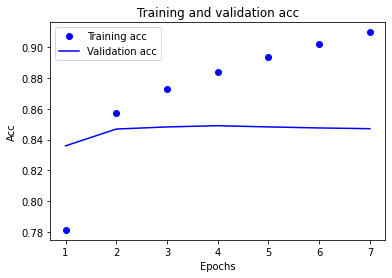

In [21]:
show_loss_acc(history_lstm, 'acc') # show LSTM accuracy

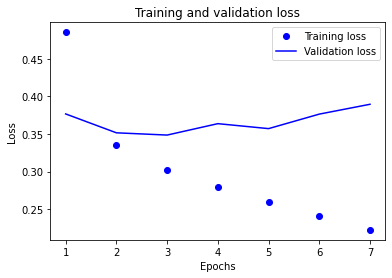

In [22]:
show_loss_acc(history_lstm, 'loss') # show LSTM loss

#### (2) GRU

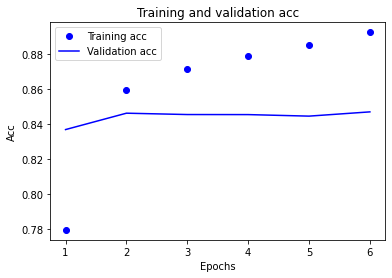

In [23]:
show_loss_acc(history_gru, 'acc') # show GRU accuracy

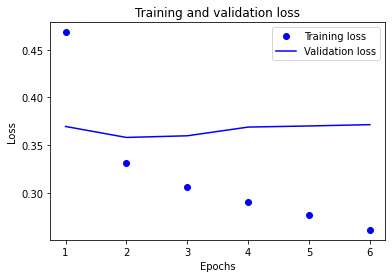

In [24]:
show_loss_acc(history_gru, 'loss') # show GRU loss

#### (3) CNN

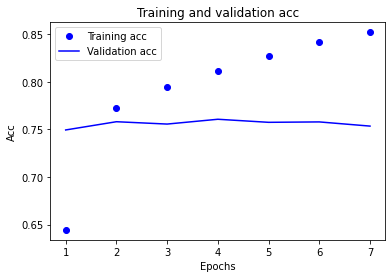

In [25]:
show_loss_acc(history_cnn, 'acc') # show CNN accuracy

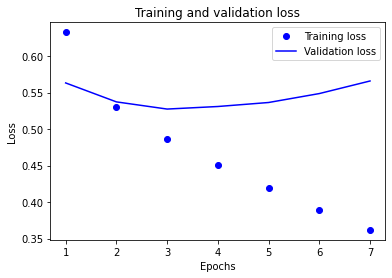

In [26]:
show_loss_acc(history_cnn, 'loss') # show CNN loss

### 7) 학습된 Embedding 레이어 분석

#### (1) LSTM

In [27]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 50)


In [28]:
# 학습시킨 LSTM 임베딩 기준 분석
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['눈물']
vector

array([ 0.02250217,  0.01817851,  0.06397052, -0.08029215,  0.12298011,
        0.13297799, -0.03351348,  0.06336   ,  0.12414656,  0.15220393,
        0.03310877, -0.09537593, -0.10961172, -0.07338115,  0.0509093 ,
       -0.12811579, -0.0630388 , -0.1451203 , -0.041053  , -0.11238141,
       -0.07456219,  0.0528366 , -0.14087129, -0.01531045, -0.02333298,
        0.07516896,  0.11475593, -0.11065506, -0.11377668, -0.13321857,
       -0.06473805,  0.13018511, -0.09452048, -0.08179506, -0.09643644,
       -0.15718602, -0.04832184,  0.04066693, -0.00737425, -0.07759224,
       -0.0199709 , -0.05869842, -0.0499011 ,  0.07844366,  0.12353416,
        0.05803116, -0.10619482, -0.07942841, -0.06097802,  0.09490562],
      dtype=float32)

In [29]:
word_vectors.similar_by_word('눈물') # '눈물'과 유사도가 높은 단어

[('해학', 0.9156970977783203),
 ('물결', 0.9121577143669128),
 ('울림', 0.9120380878448486),
 ('어깨', 0.9107088446617126),
 ('집니다', 0.909222424030304),
 ('류덕환', 0.9088531136512756),
 ('이제야', 0.9084336757659912),
 ('단연', 0.9069399833679199),
 ('여사', 0.9068281650543213),
 ('아자니', 0.9067018032073975)]

#### (2) GRU

In [30]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_gru.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_gru = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gru.txt'
f = open(word2vec_file_path_gru, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_gru.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 50)


In [31]:
# 학습시킨 GRU 임베딩 기준 분석
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gru, binary=False)
vector = word_vectors['눈물']
vector

array([ 0.0701882 , -0.06856277, -0.03365883, -0.04853345,  0.12975   ,
        0.05597989, -0.09366162, -0.09051331,  0.10847683,  0.00962175,
        0.12341167, -0.05942428, -0.0512224 , -0.08249143,  0.0896984 ,
        0.0986124 ,  0.0330268 , -0.10550837, -0.12303093,  0.10580874,
       -0.04264084, -0.0627771 ,  0.08039362, -0.00389892, -0.09637341,
       -0.10166103,  0.03801138,  0.07186882, -0.03946818, -0.07801242,
       -0.11010101, -0.0637517 , -0.14087151, -0.05307387, -0.04045544,
        0.12196989,  0.05502674, -0.04417375, -0.05052267,  0.05477139,
        0.05095189, -0.02042729, -0.03372885,  0.09398637, -0.06961951,
        0.10747238,  0.08140624, -0.01423742, -0.08240912, -0.09975064],
      dtype=float32)

In [32]:
word_vectors.similar_by_word('눈물') # '눈물'과 유사도가 높은 단어

[('귀여움', 0.9238154888153076),
 ('이만', 0.9183204770088196),
 ('명화', 0.9115661978721619),
 ('재판', 0.9071007370948792),
 ('써요', 0.9058616161346436),
 ('올라가', 0.9052035808563232),
 ('울림', 0.9047932624816895),
 ('다섯', 0.9037443995475769),
 ('센', 0.901559591293335),
 ('퍼스', 0.8997529745101929)]

#### (3) 1D CNN

In [33]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim_cnn)) 

vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [34]:
# 학습시킨 CNN 임베딩 기준 분석
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['눈물']
vector

array([-0.14062169, -0.12870356, -0.07418597, -0.03013569,  0.0485132 ,
        0.05274144, -0.07858249, -0.0440316 , -0.03591715, -0.14807397,
       -0.07575764, -0.02486651, -0.02688406,  0.12838389, -0.02487549,
       -0.10751256], dtype=float32)

In [35]:
word_vectors.similar_by_word('눈물') # '눈물'과 유사도가 높은 단어

[('느껴져', 0.9496310353279114),
 ('이제야', 0.9197431802749634),
 ('진하', 0.9046112895011902),
 ('곱씹', 0.9037601947784424),
 ('투캅스', 0.9033419489860535),
 ('어렷', 0.8990650177001953),
 ('울림', 0.8984838128089905),
 ('계신', 0.8977344036102295),
 ('아쉬웠', 0.8950778841972351),
 ('재발견', 0.8946875929832458)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path =os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['눈물']
vector

array([ 4.4374938e+00, -1.7032225e+00, -1.6537160e+00,  1.3416935e+00,
        9.4176412e-01, -1.1971127e+00,  1.6244729e+00, -1.8392246e+00,
        7.9721516e-01,  8.0024487e-01,  1.6623759e-01, -7.3732167e-01,
       -7.9332733e-01, -2.1084888e+00,  3.7857047e-01, -8.7108022e-01,
       -1.4241999e-01,  7.9976755e-01,  2.3714764e+00, -3.3825223e+00,
       -1.9354525e+00,  2.8776672e+00,  2.5670559e+00, -7.5363797e-01,
        2.9734168e+00,  6.2005687e-01, -1.3553896e+00,  2.2069915e-01,
       -5.3355489e-02, -5.3975735e+00, -4.3731409e-01,  7.8842950e-01,
       -8.5420680e-01,  1.5157185e+00, -4.8801342e-01,  1.5634551e+00,
       -1.0215125e+00, -7.4927783e-01, -4.4310506e-02,  2.2635355e+00,
       -2.5876187e-02,  7.4778032e-01,  1.9505405e+00,  3.1145375e+00,
       -1.3103136e+00, -4.0422589e-01,  2.2826233e+00, -3.3591056e+00,
        2.8697922e+00, -2.7999628e+00, -1.7109917e+00,  7.7499753e-01,
        2.2487674e+00, -3.8421981e+00, -2.7603438e+00, -2.1950996e-01,
      

In [37]:
word2vec.wv.similar_by_word('눈물') # Word2Vec의 임베딩 기반 '눈물'과 유사도가 높은 단어

[('웃음', 0.7543492317199707),
 ('슬픔', 0.7267216444015503),
 ('한숨', 0.7182712554931641),
 ('피눈물', 0.7141152024269104),
 ('땀', 0.7121106386184692),
 ('이별', 0.695806622505188),
 ('가슴', 0.6698150038719177),
 ('기쁨', 0.657920241355896),
 ('머리카락', 0.6576725840568542),
 ('꿈', 0.6558417677879333)]

In [60]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]
        
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100
hidden_units = 200

model = Sequential()
model.add(Embedding(vocab_size, 
                         word_vector_dim, 
                         embeddings_initializer=Constant(embedding_matrix), # 위의 임베딩 사용
                         input_length=50,
                         trainable=True))
model.add(LSTM(hidden_units)) # LSTM 선택
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 1,241,001
Trainable params: 1,241,001
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train, y_train, epochs=20, callbacks=es, batch_size=512,\
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
172/172 [==============================] - 7s 30ms/step - loss: 0.4966 - accuracy: 0.7531 - val_loss: 0.4173 - val_accuracy: 0.8105
Epoch 2/20
172/172 [==============================] - 5s 28ms/step - loss: 0.3638 - accuracy: 0.8394 - val_loss: 0.3568 - val_accuracy: 0.8424
Epoch 3/20
172/172 [==============================] - 5s 28ms/step - loss: 0.3057 - accuracy: 0.8682 - val_loss: 0.3351 - val_accuracy: 0.8551
Epoch 4/20
172/172 [==============================] - 5s 28ms/step - loss: 0.2656 - accuracy: 0.8885 - val_loss: 0.3495 - val_accuracy: 0.8492
Epoch 5/20
172/172 [==============================] - 5s 28ms/step - loss: 0.2318 - accuracy: 0.9054 - val_loss: 0.3383 - val_accuracy: 0.8594
Epoch 6/20
172/172 [==============================] - 5s 29ms/step - loss: 0.1992 - accuracy: 0.9208 - val_loss: 0.3529 - val_accuracy: 0.8598
Epoch 7/20
172/172 [==============================] - 5s 29ms/step - loss: 0.1714 - accuracy: 0.9336 - val_loss: 0.3799 - val_accuracy: 0.8588

In [62]:
results = model.evaluate(X_test,  y_test, verbose=2) # 성능이 약간 높아짐

1537/1537 - 4s - loss: 0.3837 - accuracy: 0.8562
